In [40]:
import proba_modules as pm
import numpy as np
from pyrocko import moment_tensor as mtm
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib import ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
from tqdm import tqdm

import VCD_trajectory_modules as VCD
import proba_volcanoes_modules as pvm

## Loading TL curves

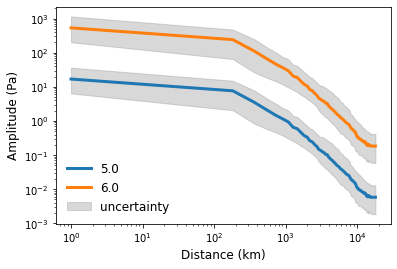

In [2]:
reload(pm)
file_curve = './data/GF_Dirac_1Hz_all.csv'
TL_new, TL_new_qmin, TL_new_qmax = pm.get_TL_curves(file_curve, dist_min=100., rho0=67., rhob=2.792, cb=304., use_savgol_filter=True, plot=True, scalar_moment=10e6)

## Loading seismo-volcanic catalog

In [3]:
catalog_hawai = pd.read_csv('./data/hawai_catalog.csv', header=[0])
catalog_hawai = catalog_hawai.loc[catalog_hawai.mag>=3.5]
all_mags = catalog_hawai.mag.values
all_times = catalog_hawai['time (years)'].values
#plt.figure()
#_=plt.hist2d(all_times, all_mags, bins=10)

## Load atmospheric model

In [9]:
reload(VCD)

file_atmos = './data/VCD_atmos_globe.dat'
altitude = 40e3
winds = VCD.get_winds(file_atmos, altitude)

/staff/quentin/Documents/Projects/2024_Venus_Detectability/VCD_trajectory_modules.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winds['gid'] = winds.groupby(['lat', 'lon'])['val'].transform('idxmin')
/staff/quentin/Documents/Projects/2024_Venus_Detectability/VCD_trajectory_modules.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winds['wind_strength'] = winds.groupby(['lat', 'lon'])['val'].transform(lambda x: np.sqrt(sum(x**2)))
/staff/quentin/Documents/Projects/2024_Venus_Detectability/VCD_traje

In [18]:
reload(VCD)
wind_direction_interpolator, wind_strength_interpolator, _ = VCD.get_winds_interpolator(file_atmos, altitude, winds=winds)

## Parameter space for flights

In [ ]:
R0 = 6371000  # Earth's radius in meters
lat_vol, lon_vol = -32.5, 132.1
lat_offset, lon_offset = np.linspace(-30., 30., 50), np.linspace(-20., 20., 40)
t0s_offset = np.arange(all_times.min()-2./12, all_times.max()-2./12, 1/12) # in years
#vlat = -0.4  # Latitude velocity in meters per second
vlon = -50/110.  # Longitude velocity in meters per second
mission_duration = (2./12.)*365*24*3600
arrival_time = lambda dist, h_balloon, t0: t0 + (h_balloon/0.35 + dist/3.5)

LAT_offset, LON_offset, T0s_offset = np.meshgrid(lat_offset, lon_offset, t0s_offset)
LAT_offset_shape = LAT_offset.shape
LAT_offset, LON_offset, T0s_offset = LAT_offset.ravel(), LON_offset.ravel(), T0s_offset.ravel()
lat0 = lat_vol+LAT_offset  # Initial latitude in degrees
lon0 = lon_vol+LON_offset  # Initial longitude in degrees

times = np.linspace(0, mission_duration, 100)  # Time vector from 0 to 3600 seconds in steps of 600 seconds
TIMES, ID_LAT0 = np.meshgrid(times, np.arange(LAT_offset.size))
shape_TIMES = TIMES.shape # balloon init loc/t0 x balloon flight time 
TIMES, ID_LAT0 = TIMES.ravel(), ID_LAT0.ravel() 

In [48]:
t0s_offset.shape

(168,)

In [41]:
reload(pvm)

latitudes, longitudes = pvm.compute_positions_vectorized_w_interpolator(lat0[ID_LAT0].reshape(shape_TIMES), lon0[ID_LAT0].reshape(shape_TIMES), wind_direction_interpolator, wind_strength_interpolator, TIMES.reshape(shape_TIMES), R0)
#latitudes, longitudes = compute_positions_vectorized(lat0[ID_LAT0].reshape(shape_TIMES), lon0[ID_LAT0].reshape(shape_TIMES), vlat_func, vlon, TIMES.reshape(shape_TIMES), R0)
distances = pvm.haversine_distance(latitudes, longitudes, lat_vol, lon_vol, R0)

100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


## Compute SNR at each balloon location

In [44]:
reload(pvm)

mags_ev, amps_ev, mask = pvm.get_amps_at_baloons(T0s_offset, LAT_offset, ID_LAT0, TIMES, times, shape_TIMES, all_times, all_mags, distances, TL_new, arrival_time, batch_size)

100%|██████████| 2508/2508 [45:22<00:00,  1.09s/it]


## Visualization

In [50]:
#snr_threshold=1
#number_over_snr = ((amps_ev*(mask)/noise_level)>snr_threshold).sum(axis=0).reshape(LAT_offset_shape)
noise_level=1e-2
idamp = (amps_ev*(mask)).argmax(axis=0)[None,:]  
amps_ev_reshaped = np.take_along_axis(amps_ev*(mask) + 1e-10*(~mask), idamp, axis=0)[0].reshape(LAT_offset_shape) # lon x lat x t0

In [83]:
number_over_snr.shape

(336000,)

(0.001, 10)

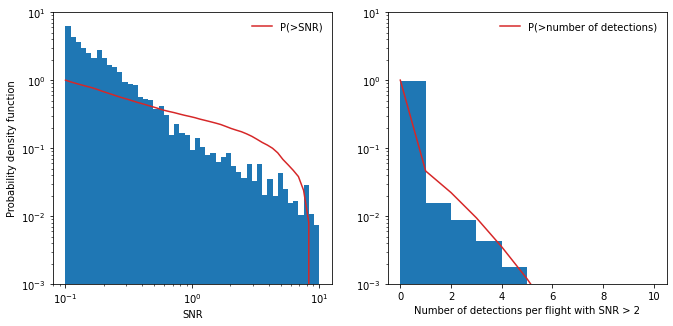

In [128]:
import matplotlib.colors as colors
#amps_ev_reshaped_over_snr = amps_ev_reshaped/noise_level>=snr_threshold
snr_threshold=2
noise_level=1e-2
number_over_snr = ((amps_ev*(mask)/noise_level)>snr_threshold).sum(axis=0)
norm=colors.LogNorm()

fig = plt.figure(figsize=(11,5))
grid = fig.add_gridspec(1, 2)

ax = fig.add_subplot(grid[0,0])
#plt.hist2d(T0s_offset, field, bins=100, range=[[0, 12], [0, 10]], norm=norm)
field = amps_ev_reshaped.ravel()/noise_level
bins = np.logspace(np.log10(0.1),np.log10(10.), 50)
#bins = np.linspace(0.1,10., 50)
hist = ax.hist(field, bins=bins, log=True, density=True)
ax.set_xscale('log')

#ax2 = ax.twinx()
vals = []
for threshold in hist[1][:-1]:
    idx = hist[1][:-1] >= threshold
    integral = np.trapz(hist[0][idx], x=hist[1][:-1][idx])/np.trapz(hist[0][:], x=hist[1][:-1][:])
    vals.append( integral )
ax.plot(hist[1][:-1], vals, color='tab:red', label='P(>SNR)')
#ax2.set_xscale('log')
#ax2.set_yscale('log')
#ax2.tick_params(axis='both', colors='tab:red',)
#ax2.set_ylim(ax.get_ylim())
ax.legend(frameon=False)

ax.set_xlabel('SNR')
#plt.ylabel('Probability density function')
ax.set_ylabel('Probability density function')

ax = fig.add_subplot(grid[0,1], sharey=ax)
#plt.hist2d(T0s_offset, field, bins=100, range=[[0, 12], [0, 10]], norm=norm)
#bins = np.logspace(np.log10(0.1),np.log10(10.), 50)
field = number_over_snr
hist = plt.hist(field, bins=10, log=True, density=True)

vals = []
for threshold in hist[1][:-1]:
    idx = hist[1][:-1] >= threshold
    integral = np.trapz(hist[0][idx], x=hist[1][:-1][idx])/np.trapz(hist[0][:], x=hist[1][:-1][:])
    vals.append( integral )
ax.plot(hist[1][:-1], vals, color='tab:red', label='P(>number of detections)')
ax.legend(frameon=False)

#plt.xscale('log')
ax.set_xlabel(f'Number of detections per flight with SNR > {snr_threshold}')
ax.set_ylim([1e-3, 10])
#ax.set_ylabel('Probability density function')

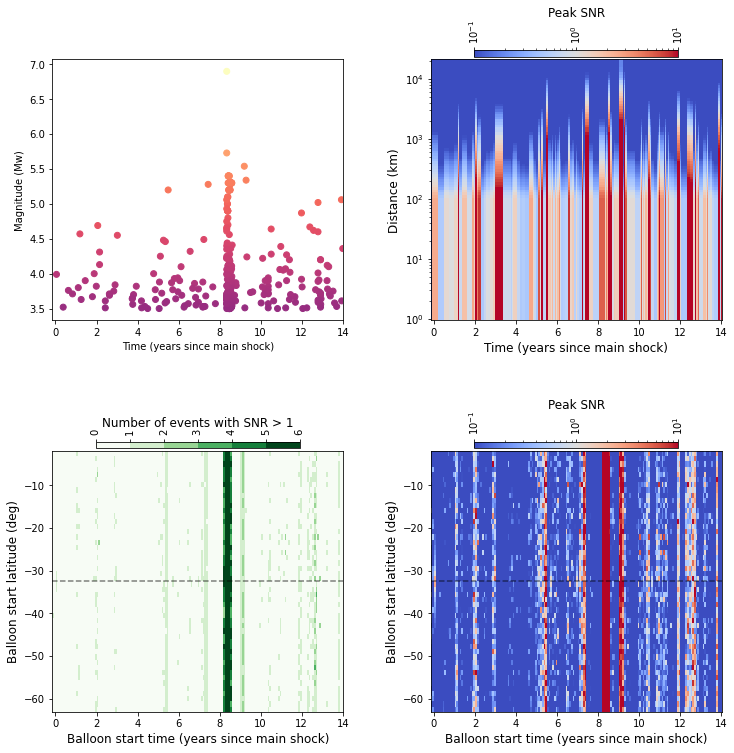

In [46]:
reload(pvm)

pvm.plot_proba_sequence(amps_ev, all_times, all_mags, TL_new, lat_vol, t0s_offset, lat_offset, LAT_offset_shape, mask, noise_level=1e-2, factor = (np.log10(2.)+4.)/4., snr_threshold=1)

In [ ]:
lons, lats = np.linspace(-30, -20, 40), np.linspace(0, 10, 50)
lons, lats = np.meshgrid(lons, lats)
lons, lats = lons.ravel(), lats.ravel()
gaussian = lambda mean, std
prob_grid = np.exp

flat_locations = np.c_[lons, lats]
flat_probs = prob_grid.flatten()
mean = np.average(flat_locations, axis=0, weights=flat_probs)

## Old - Test and random data generation

In [ ]:
reload(pm)

file_slopes = './data/Venus_data/distribution_venus_per_mw.csv'
pd_slopes = pm.get_slopes(file_slopes)

In [2]:
def return_number_per_cat_and_setting(pd_slopes, cat_quake, setting):
    
    slope = pd_slopes.loc[(pd_slopes.type_setting==setting)&(pd_slopes.type_unknown=='slope'), cat_quake].iloc[0]
    intercept = pd_slopes.loc[(pd_slopes.type_setting==setting)&(pd_slopes.type_unknown=='intercept'), cat_quake].iloc[0]
    func = lambda mw: 10**(np.log10(mtm.magnitude_to_moment(mw))*slope+intercept)
    return func

MwOverM0 = return_number_per_cat_and_setting(pd_slopes, 'coronae', 'active_high_max')
MwOverM02 = return_number_per_cat_and_setting(pd_slopes, 'coronae', 'active_low_min')

In [ ]:
idx = 40
plt.figure()
sc = plt.scatter(longitudes.reshape(shape_TIMES)[idx,:], latitudes.reshape(shape_TIMES)[idx,:], c=times)
plt.colorbar(sc)
plt.scatter(lon_vol, lat_vol, marker='^', s=100, color='tab:red')
plt.xlim([-180., 180.])
plt.ylim([-90., 90.])

In [ ]:
def add_cbar(ax, sc, label):

    axins = inset_axes(ax, width="70%", height="2.5%", loc='lower left', 
                    bbox_to_anchor=(0.15, 1.01, 1, 1.), bbox_transform=ax.transAxes, borderpad=0)
    axins.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False, labelrotation=90.)
    cbar = plt.colorbar(sc, cax=axins, extend='both', orientation="horizontal")  
    cbar.ax.xaxis.set_ticks_position('top') 
    cbar.ax.xaxis.set_label_position("top")
    cbar.ax.xaxis.tick_top()
    cbar.ax.set_xlabel(label, labelpad=2) 

mags = np.linspace(2., 6., 200)
tmax = 2.
tsecondshocks = 1.1
times = np.linspace(0., tmax, 150)
dists = np.linspace(1., 1000., 100)
scaling_min, scaling_max = 5e2, 1e6
noise_level = 0.05
mission_duration = 1./12.

poisson_model = lambda rate, mission_duration : 1.-np.exp(-rate*mission_duration)
ID_TIME, DISTS = np.meshgrid(np.arange(times.size), dists)
alpha = (1/tmax)*np.log(scaling_max/scaling_min)
scalings = lambda times: scaling_min*np.exp(times*alpha)
MAGS, TIMES = np.meshgrid(mags, times)
shape_init = MAGS.shape
NUMBERS = MwOverM0(MAGS)/scalings(TIMES)
NUMBERS = NUMBERS.ravel()
NUMBERS[NUMBERS<1] = 0

NUMBERS2 = np.zeros_like(NUMBERS)
inds = TIMES.ravel()>=tsecondshocks
NUMBERS2[inds] = (MwOverM02(MAGS.ravel())/scalings(TIMES.ravel()-tsecondshocks))[inds]

NUMBERS += NUMBERS2
NUMBERS = NUMBERS.astype(int).reshape(shape_init)

# Create a mask for non-zero events
mask = NUMBERS > 0
magnitude_matrix = np.where(mask, MAGS, -np.inf)
max_magnitudes = np.max(magnitude_matrix, axis=1)

fig = plt.figure(figsize=(15,5))
grid = fig.add_gridspec(1, 3)

ax = fig.add_subplot(grid[0,0])
#sc = ax.contourf(TIMES, MAGS, NUMBERS, cmap='Reds', locator=ticker.LogLocator(), levels=[1, 5, 10, 50, 100, 1000])
ax.plot(times, max_magnitudes, color='tab:red',)
ax.set_xlabel('Time (years)')
ax.set_ylabel('Peak Moment Magnitude ($M_w$)')
#add_cbar(ax, sc, f'Number of events')

ax = fig.add_subplot(grid[0,1])
sc = ax.contourf(times[ID_TIME], DISTS, TL_new(DISTS, max_magnitudes[ID_TIME]), locator=ticker.LogLocator(), cmap='Blues', )
ax.set_xlabel('Time (years)')
ax.set_ylabel('Distance (km)')
add_cbar(ax, sc, f'Peak Amplitude (Pa)')
TL_new(DISTS, max_magnitudes[ID_TIME])

ax = fig.add_subplot(grid[0,2])
sc = ax.contourf(times[ID_TIME], DISTS, TL_new(DISTS, max_magnitudes[ID_TIME])/noise_level, locator=ticker.LogLocator(), cmap='Greens', )
ax.set_xlabel('Time (years)')
ax.set_ylabel('Distance (km)')
add_cbar(ax, sc, f'Peak SNR')

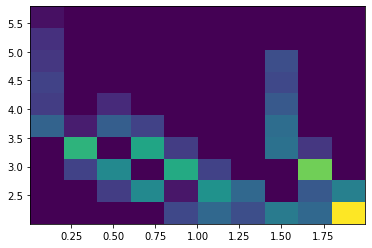

In [64]:
# Parameters for the Gaussian distribution
mag_min = 2.0  # mean of the distribution
mag_maxs = [6., 4., 5.]
t0s = [0., 0.5, 1.4]
#mag_maxs = [5.,]
#t0s = [0.,]
std_dev = 1.5  # standard deviation of the distribution
tmax = 2.
n = 200  # number of samples

# Sampling n elements from the Gaussian distribution
np.random.seed(1)
all_mags = np.array([])
all_times = np.array([])
for t0, mag_max in zip(t0s, mag_maxs):
    mags = np.random.normal(loc=mag_min, scale=std_dev, size=5*n)
    mags = mags[(mags>=mag_min)&(mags<=mag_max)][:n]
    all_mags = np.r_[all_mags, np.sort(mags)[::-1]]
    times = np.random.normal(loc=t0, scale=tmax/3., size=5*n)
    times = times[(times>=t0)&(times<=tmax)][:n]
    all_times = np.r_[all_times, np.sort(times)]
    
plt.figure()
_=plt.hist2d(all_times, all_mags, bins=10)
#plt.scatter(all_times, all_mags)

In [ ]:
all_times.shape